## Imports

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import polars as pl
from pathlib import Path
import subprocess

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib_venn import venn2

## Confuguration and Data Download

In [2]:
DORADO_FILE = Path('../Exemplar_Data/parquet_files/Dorado_filtered_20_20_m.parquet')

DATA_URLS = {
    'm5c_ubs': 'https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE225614&format=file&file=GSE225614%5FHEK293T%2DWT%5Fsites%2Etsv%2Egz'
}

DATA_DIR = Path("../Exemplar_Data/orthogonal_data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

for name, url in DATA_URLS.items():
    output_file = DATA_DIR / Path(url).name
    if not output_file.exists():
        subprocess.run(['wget', '-q', '-O', str(output_file), url], check=True)

M5C_FILE = DATA_DIR / "GSE225614_HEK293T-WT_sites.tsv.gz"

## Color Scheme

In [3]:
M5C_COLORS = {
    'DRS_HEK293': '#2ca02c',
    'Orthogonal': '#e377c2',
}

ALPHA = 0.7

## Data Loader

In [4]:
from typing import Union, Any

class OrthogonalDataloader:
    def __init__(self, file_path: Union[Path, str]) -> None:
        self.file_path = Path(file_path)
        if not self.file_path.is_file():
            raise FileNotFoundError(f"File not found: '{self.file_path}'")

    def load_data(self, **kwargs: Any) -> Union[pd.DataFrame, dict, Any]:
        suffixes = self.file_path.suffixes
        compression = 'gzip' if '.gz' in suffixes else None
        
        try:
            if '.tsv' in suffixes or '.txt' in suffixes:
                if 'sep' not in kwargs:
                    kwargs['sep'] = '\t'
                return pd.read_csv(self.file_path, compression=compression, **kwargs)
            else:
                raise ValueError(f"Unsupported file type: {''.join(suffixes)}")
        
        except Exception as e:
            print(f"Failed to load {self.file_path.name}: {e}")
            return None

## Load all data

In [5]:
hek293_m5c_drs = pl.read_parquet(DORADO_FILE)

# UBS-Seq
loader = OrthogonalDataloader(M5C_FILE)
m5c_raw = loader.load_data()
m5c_orthogonal_df = m5c_raw[
    ~(m5c_raw['gene_type'] == 'rRNA') & ~(m5c_raw['gene_type'] == 'tRNA')
].copy()

## Helper Functions

In [6]:
from typing import Set

def get_drs_sites(df: pl.DataFrame) -> Set[str]:
    df_filtered = df.filter((pl.col('IVT_Adjusted_Mod_Percent') >= 20) & (pl.col('Score') >= 20))
    
    sample_chr = df_filtered['Chromosome'][0] if len(df_filtered) > 0 else None
    if sample_chr and not str(sample_chr).startswith('chr'):
        sites = set(('chr' + df_filtered['Chromosome'].cast(pl.Utf8) + '_' + 
                    df_filtered['End'].cast(pl.Int64).cast(pl.Utf8)).to_list())
    else:
        sites = set((df_filtered['Chromosome'].cast(pl.Utf8) + '_' + 
                    df_filtered['End'].cast(pl.Int64).cast(pl.Utf8)).to_list())
    return sites

def process_orthogonal_sites(df, chr_col: str, pos_col: str) -> Set[str]:
    if df is None:
        return set()
    
    sample_chr = str(df[chr_col].iloc[0]) if len(df) > 0 else None
    pos_int = df[pos_col].astype(float).astype(int).astype(str)
    if sample_chr and sample_chr.startswith('chr'):
        sites = set(df[chr_col].astype(str) + '_' + pos_int)
    else:
        sites = set('chr' + df[chr_col].astype(str) + '_' + pos_int)
    return sites

In [7]:
drs_sites = get_drs_sites(hek293_m5c_drs)
orth_sites = process_orthogonal_sites(m5c_orthogonal_df, 'chromosome', 'position')

print(f"HEK293 DRS: {len(drs_sites):,} sites")
print(f"UBS-Seq: {len(orth_sites):,} sites")
print(f"Overlap: {len(drs_sites & orth_sites):,}")

HEK293 DRS: 44 sites
UBS-Seq: 2,191 sites
Overlap: 0


## Plotting

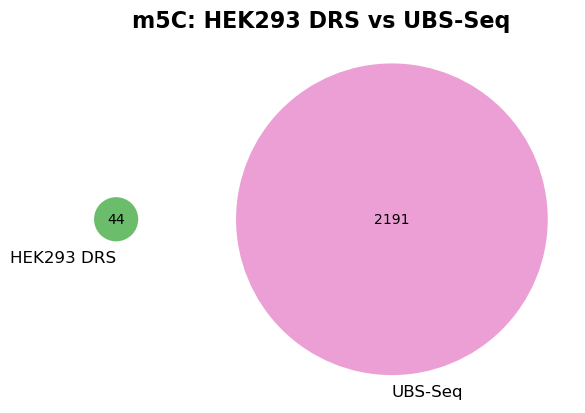

In [8]:
fig, ax = plt.subplots(figsize=(6, 6))

venn2([drs_sites, orth_sites],
      set_labels=['HEK293 DRS', 'UBS-Seq'],
      set_colors=[M5C_COLORS['DRS_HEK293'], M5C_COLORS['Orthogonal']],
      alpha=ALPHA,
      ax=ax)

ax.set_title('m5C: HEK293 DRS vs UBS-Seq', 
             fontweight='bold', fontsize=16)

plt.tight_layout()
plt.show()